Transaction level return prediction: Predict IsReturn for each invoice

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE #install imbalanced-learn
import shap
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('online_retail_cleaned.csv')

In [4]:
df.IsReturn.value_counts()

IsReturn
0    390504
1      7421
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397925 entries, 0 to 397924
Data columns (total 68 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Invoice                       397925 non-null  int64  
 1   StockCode                     397925 non-null  object 
 2   Description                   397925 non-null  object 
 3   Quantity                      397925 non-null  int64  
 4   InvoiceDate                   397925 non-null  object 
 5   Price                         397925 non-null  float64
 6   Customer ID                   397925 non-null  float64
 7   Country                       397925 non-null  object 
 8   IsReturn                      397925 non-null  int64  
 9   InvoiceHour                   397925 non-null  int64  
 10  Time_Afternoon                397925 non-null  int64  
 11  Time_Evening                  397925 non-null  int64  
 12  Time_Morning                  397925 non-nul

In [6]:
# Define target variable
y = df['IsReturn']

# Drop columns that should not be used as features
X = df.drop(columns=['Customer ID','IsReturn', 'Invoice', 'InvoiceDate', 'StockCode','Description',"Country"]) 

In [7]:
""" showing use of stratify in train_test_split """

"""
# Without stratify
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y, test_size=0.2, random_state=42)
print("Without Stratify:")
print(y_train_ns.value_counts(normalize=True))  # May be skewed
print(y_test_ns.value_counts(normalize=True))  # May not match original ratio

# With stratify
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("With Stratify:")
print(y_train_s.value_counts(normalize=True))  # Same ratio as original
print(y_test_s.value_counts(normalize=True))  # Same ratio as original"
"""

'\n# Without stratify\nX_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y, test_size=0.2, random_state=42)\nprint("Without Stratify:")\nprint(y_train_ns.value_counts(normalize=True))  # May be skewed\nprint(y_test_ns.value_counts(normalize=True))  # May not match original ratio\n\n# With stratify\nX_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nprint("With Stratify:")\nprint(y_train_s.value_counts(normalize=True))  # Same ratio as original\nprint(y_test_s.value_counts(normalize=True))  # Same ratio as original"\n'

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Ensures class ratio consistency
    random_state=42
)

In [9]:
# weight ratio between the majority class (non-returns) and the minority class (returns) in the training data.
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 52.62


The scale_pos_weight parameter tells XGBoost to penalize the majority class less and the minority class more, so the model takes returns (IsReturn == 1) more seriously.

Each return is treated as 52 times more important than a non-return.

In [10]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [11]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     78101
           1       0.06      0.85      0.11      1484

    accuracy                           0.74     79585
   macro avg       0.53      0.80      0.48     79585
weighted avg       0.98      0.74      0.84     79585

AUC-ROC: 0.8875438470007959
AUC-PR: 0.21826564255830552


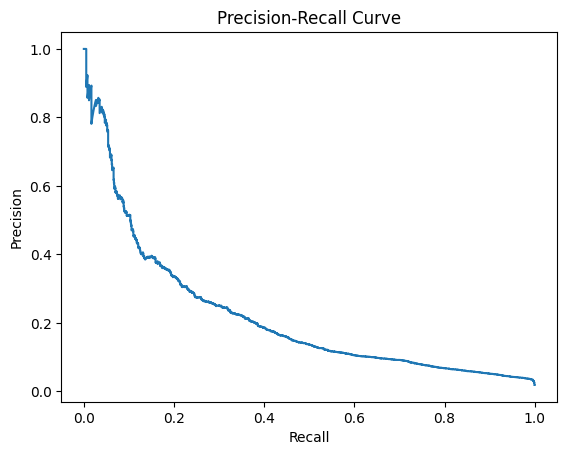

In [12]:
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr}")

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

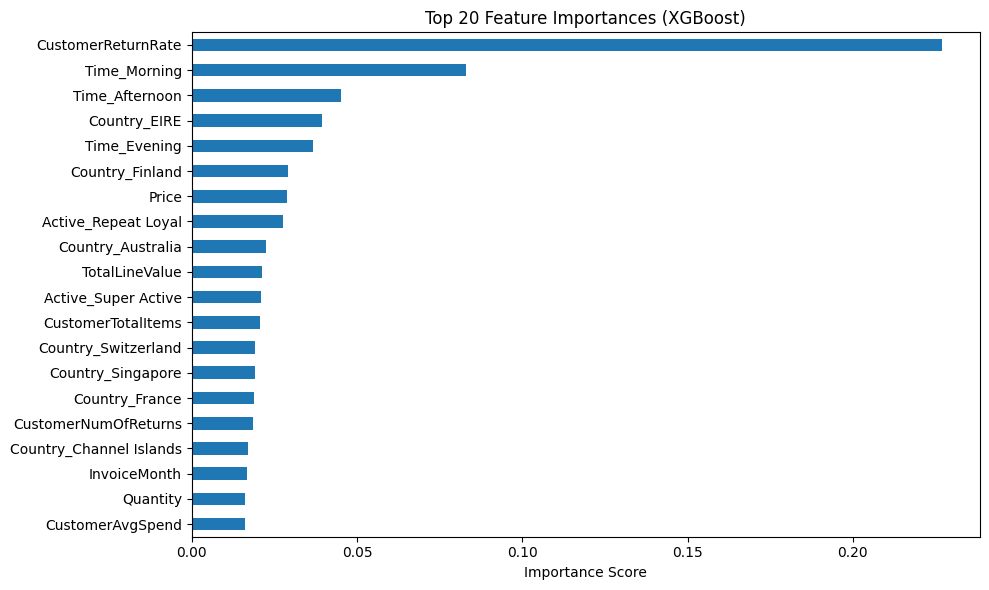

In [13]:
# Get feature importances (based on gain by default)
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Plot top features
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


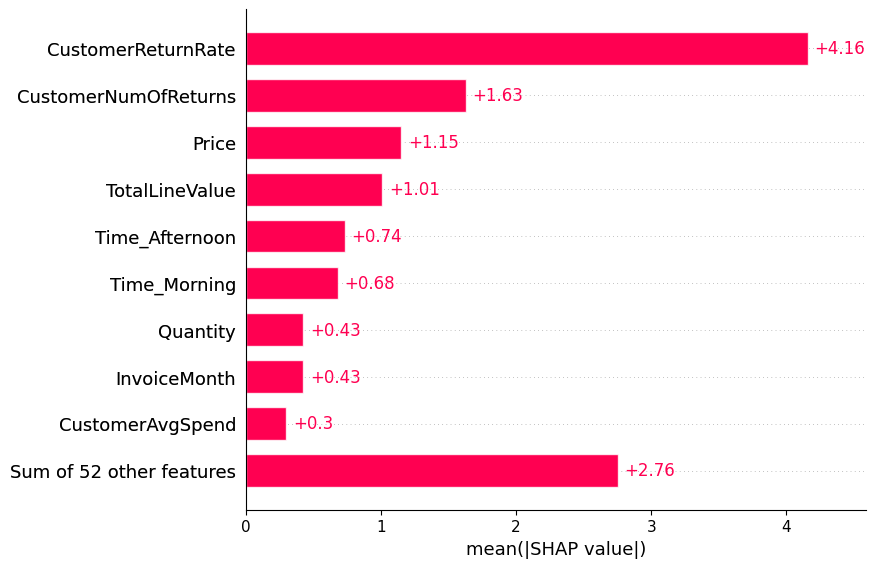

In [14]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

# Global importance
shap.plots.bar(shap_values)

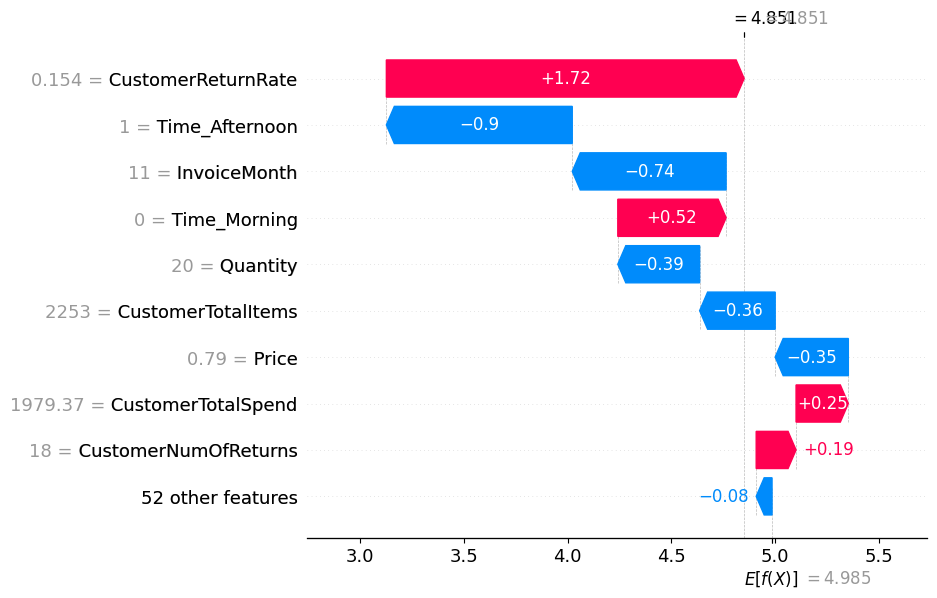

In [15]:
shap.plots.waterfall(shap_values[0])  # Explain a single prediction

Don't use SMOTE only scale_pos_weight

In [16]:
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.84      0.91     78101
           1       0.09      0.77      0.15      1484

    accuracy                           0.84     79585
   macro avg       0.54      0.80      0.53     79585
weighted avg       0.98      0.84      0.90     79585

AUC-ROC: 0.9025156269245805
AUC-PR: 0.27084294403941406


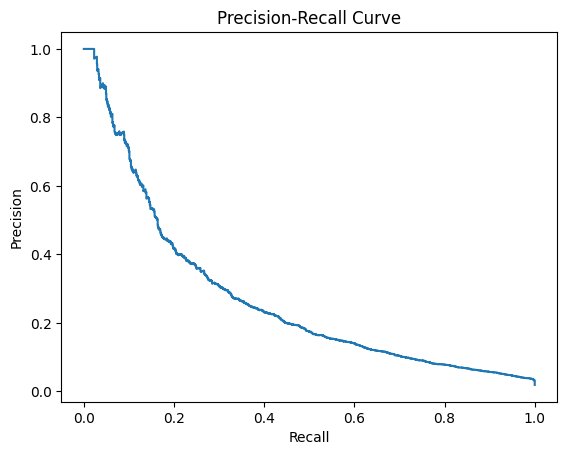

In [17]:
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr}")

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

Add a threshold for probability predictions.

In [18]:
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid divide-by-zero

# Find the threshold that maximizes F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

Best threshold: 0.882
Precision: 0.295, Recall: 0.319, F1: 0.307


In [20]:
y_pred_custom = (y_pred_proba > best_threshold).astype(int)

In [21]:
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     78101
           1       0.29      0.32      0.31      1484

    accuracy                           0.97     79585
   macro avg       0.64      0.65      0.65     79585
weighted avg       0.97      0.97      0.97     79585

[[76969  1132]
 [ 1011   473]]


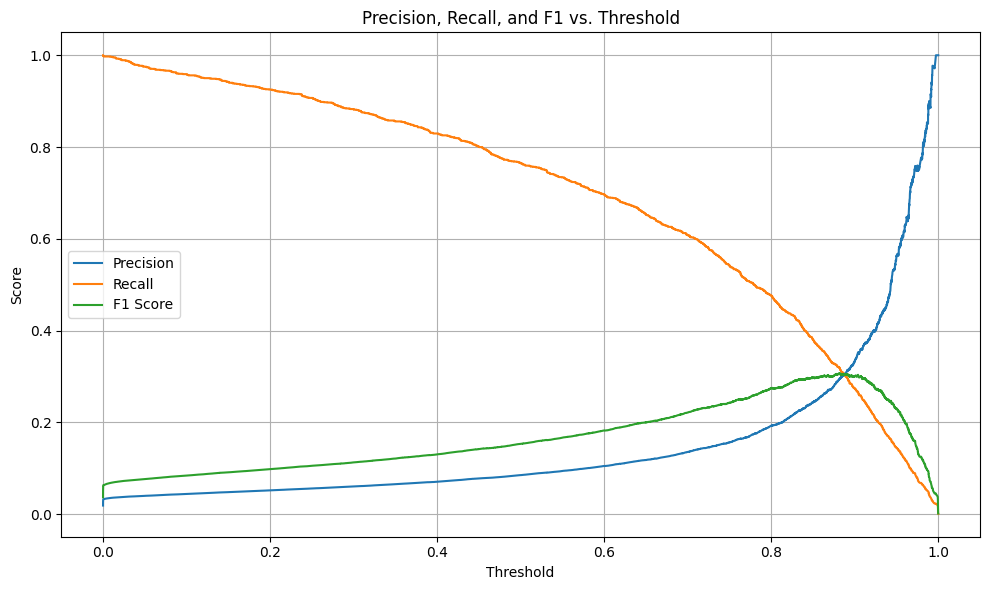

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs. Threshold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


<Axes: >

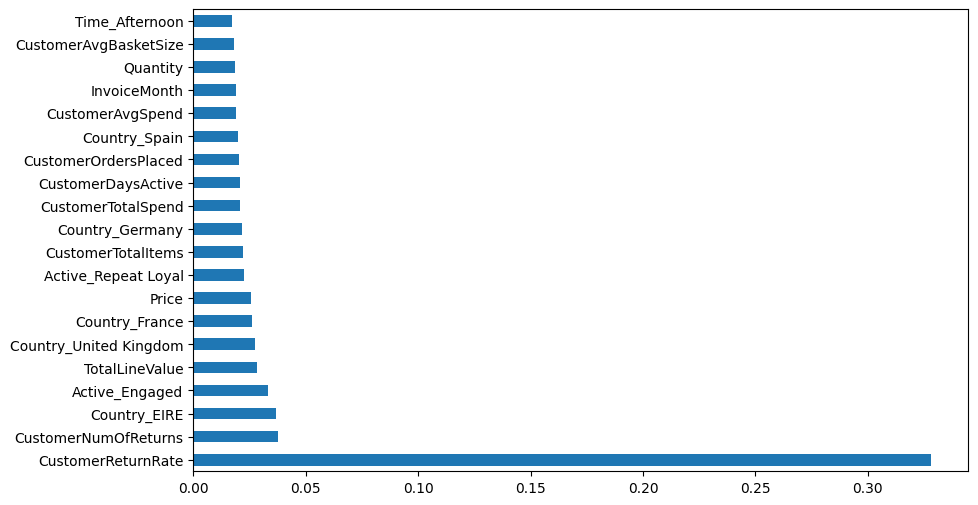

In [23]:
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
importances.head(20).plot(kind='barh', figsize=(10, 6))

Try RFE to choose most relevant 20 features

In [24]:
rfe = RFE(estimator=XGBClassifier(), n_features_to_select=20)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

In [25]:
selected_features

Index(['Quantity', 'Price', 'InvoiceHour', 'InvoiceDayOfWeek', 'InvoiceMonth',
       'TotalLineValue', 'CustomerOrdersPlaced', 'CustomerTotalItems',
       'CustomerTotalSpend', 'CustomerDaysActive', 'CustomerAvgBasketSize',
       'CustomerAvgSpend', 'CustomerLoyaltySpan', 'Active_Occasional',
       'CustomerNumOfReturns', 'CustomerReturnRate', 'Country_Australia',
       'Country_France', 'Country_Germany', 'Country_United Kingdom'],
      dtype='object')

Try SHAP

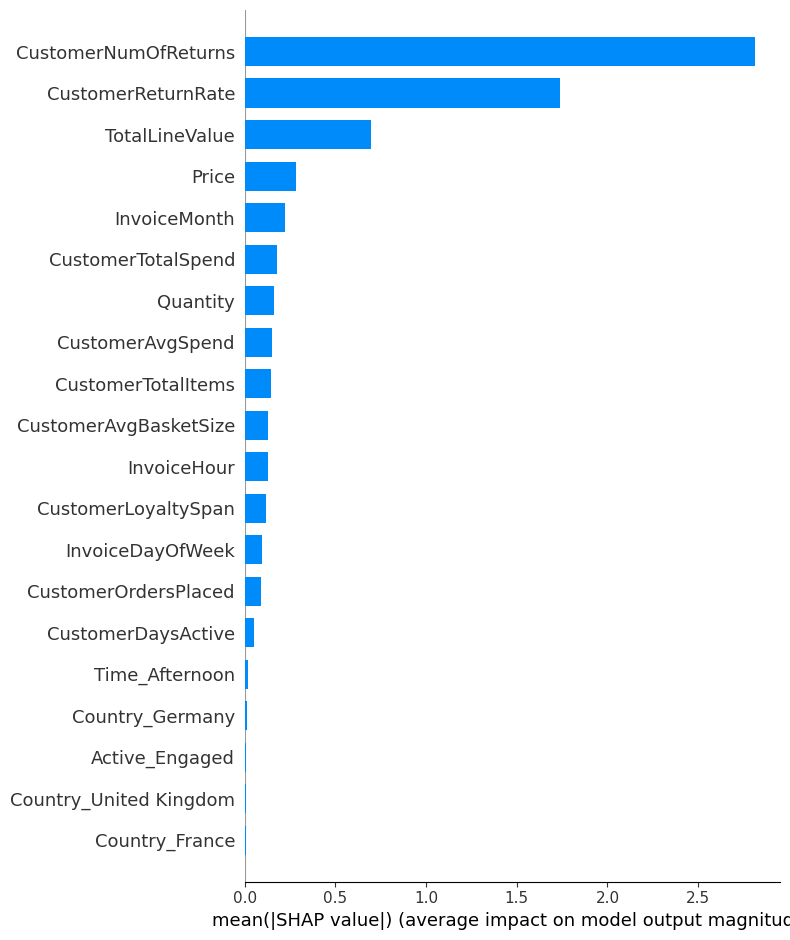

In [26]:
# Create the SHAP explainer (TreeExplainer is optimal for XGBoost)
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set (or train set if more stable)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [27]:
# Get mean absolute SHAP values for each feature
feature_importance = np.abs(shap_values).mean(axis=0)

# Create a Series with feature names
shap_importance = pd.Series(feature_importance, index=X_train.columns)
shap_importance = shap_importance.sort_values(ascending=False)

# Select top 30 features
top_features = shap_importance.head(30).index.tolist()
top_features


['CustomerNumOfReturns',
 'CustomerReturnRate',
 'TotalLineValue',
 'Price',
 'InvoiceMonth',
 'CustomerTotalSpend',
 'Quantity',
 'CustomerAvgSpend',
 'CustomerTotalItems',
 'CustomerAvgBasketSize',
 'InvoiceHour',
 'CustomerLoyaltySpan',
 'InvoiceDayOfWeek',
 'CustomerOrdersPlaced',
 'CustomerDaysActive',
 'Time_Afternoon',
 'Country_Germany',
 'Active_Engaged',
 'Country_United Kingdom',
 'Country_France',
 'Active_Repeat Loyal',
 'Country_Portugal',
 'Country_EIRE',
 'Country_Channel Islands',
 'Country_Norway',
 'Country_Singapore',
 'Country_Switzerland',
 'Country_Finland',
 'Country_Australia',
 'Country_Sweden']

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


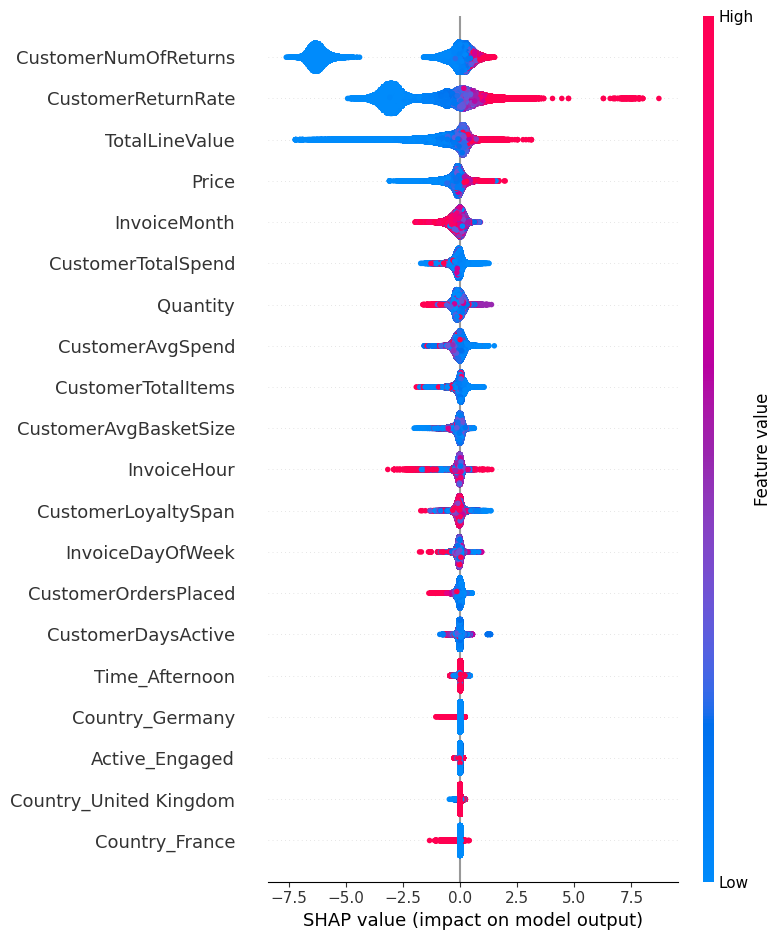

In [28]:
X_train_shap = X_train[top_features]
X_test_shap = X_test[top_features]

xgb_model.fit(X_train_shap, y_train)

shap.summary_plot(shap_values, X_train)  # Beeswarm plot

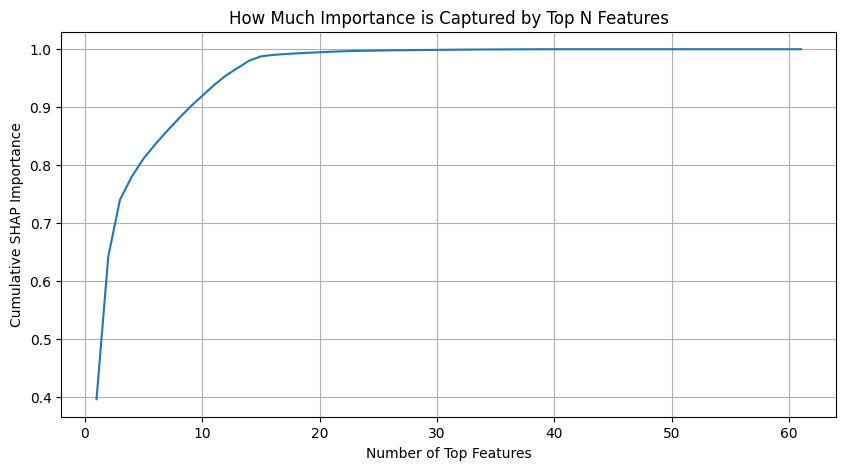

In [30]:
# Cumulative importance
cumulative = shap_importance.cumsum() / shap_importance.sum()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative)+1), cumulative.values)
plt.xlabel("Number of Top Features")
plt.ylabel("Cumulative SHAP Importance")
plt.title("How Much Importance is Captured by Top N Features")
plt.grid()
plt.show()

Around 10 features capture ~95–98% of total SHAP importance.

Look for the "elbow" or flattening point 

In [31]:
# Select features capturing 95% of SHAP importance
cumulative = shap_importance.cumsum() / shap_importance.sum()
selected_features = cumulative[cumulative <= 0.95].index.tolist()

# Check how many you kept
print(f"Selected {len(selected_features)} features:", selected_features)

Selected 11 features: ['CustomerNumOfReturns', 'CustomerReturnRate', 'TotalLineValue', 'Price', 'InvoiceMonth', 'CustomerTotalSpend', 'Quantity', 'CustomerAvgSpend', 'CustomerTotalItems', 'CustomerAvgBasketSize', 'InvoiceHour']


In [32]:
X_train_shap = X_train[selected_features]
X_test_shap = X_test[selected_features]

xgb_model.fit(X_train_shap, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [34]:
y_pred = xgb_model.predict(X_test_shap)
y_pred_proba = xgb_model.predict_proba(X_test_shap)[:, 1]

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     78101
           1       0.08      0.76      0.15      1484

    accuracy                           0.84     79585
   macro avg       0.54      0.80      0.53     79585
weighted avg       0.98      0.84      0.90     79585

AUC-ROC: 0.8996150226514005
AUC-PR: 0.25447618743249784


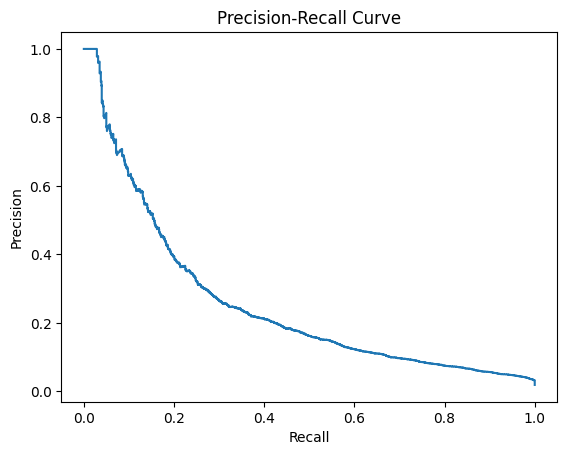

In [35]:
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr}")

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid divide-by-zero

# Find the threshold that maximizes F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

Best threshold: 0.861
Precision: 0.242, Recall: 0.348, F1: 0.285


In [37]:
y_pred_custom = (y_pred_proba > best_threshold).astype(int)

In [38]:
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     78101
           1       0.24      0.35      0.28      1484

    accuracy                           0.97     79585
   macro avg       0.61      0.66      0.63     79585
weighted avg       0.97      0.97      0.97     79585

[[76484  1617]
 [  969   515]]


In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
f1 = cross_val_score(xgb_model, X_train_shap, y_train, cv=skf, scoring='f1')
precision = cross_val_score(xgb_model, X_train_shap, y_train, cv=skf, scoring='precision')
recall = cross_val_score(xgb_model, X_train_shap, y_train, cv=skf, scoring='recall')

print("Average CV F1:", f1.mean())
print("Average CV Precision:", precision.mean())
print("Average CV Recall:", recall.mean())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [21:09:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [21:09:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [21:09:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [21:09:15] WARNING: /Users/runner/work/xgboost/xgboost/src

Average CV F1: 0.1542694491956345
Average CV Precision: 0.08606734931364568
Average CV Recall: 0.7433031522753512


In [ ]:
import joblib

joblib.dump(xgb_model, "xgb_final_model.pkl")
joblib.dump(selected_features, "selected_features.pkl")
